In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from data_utils import FaceData
from data_utils_background import FaceDataCropped
import time
import os

from classifiers.segmentation_bis import SegmentationNN

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.ion()   # interactive mode

In [2]:
train_data = FaceDataCropped(image_paths_file='LAG_background/train/train.txt')
val_data = FaceData(image_paths_file='LAG/val/val.txt')
test_data = FaceData(image_paths_file='LAG/train/train.txt')
print(train_data[0][1].size())
print(train_data[0][0].size())

torch.Size([200, 200])
torch.Size([3, 200, 200])


Train size: 1489
Validation size: 260
Img size:  torch.Size([3, 200, 200])
Segmentation size:  torch.Size([200, 200])


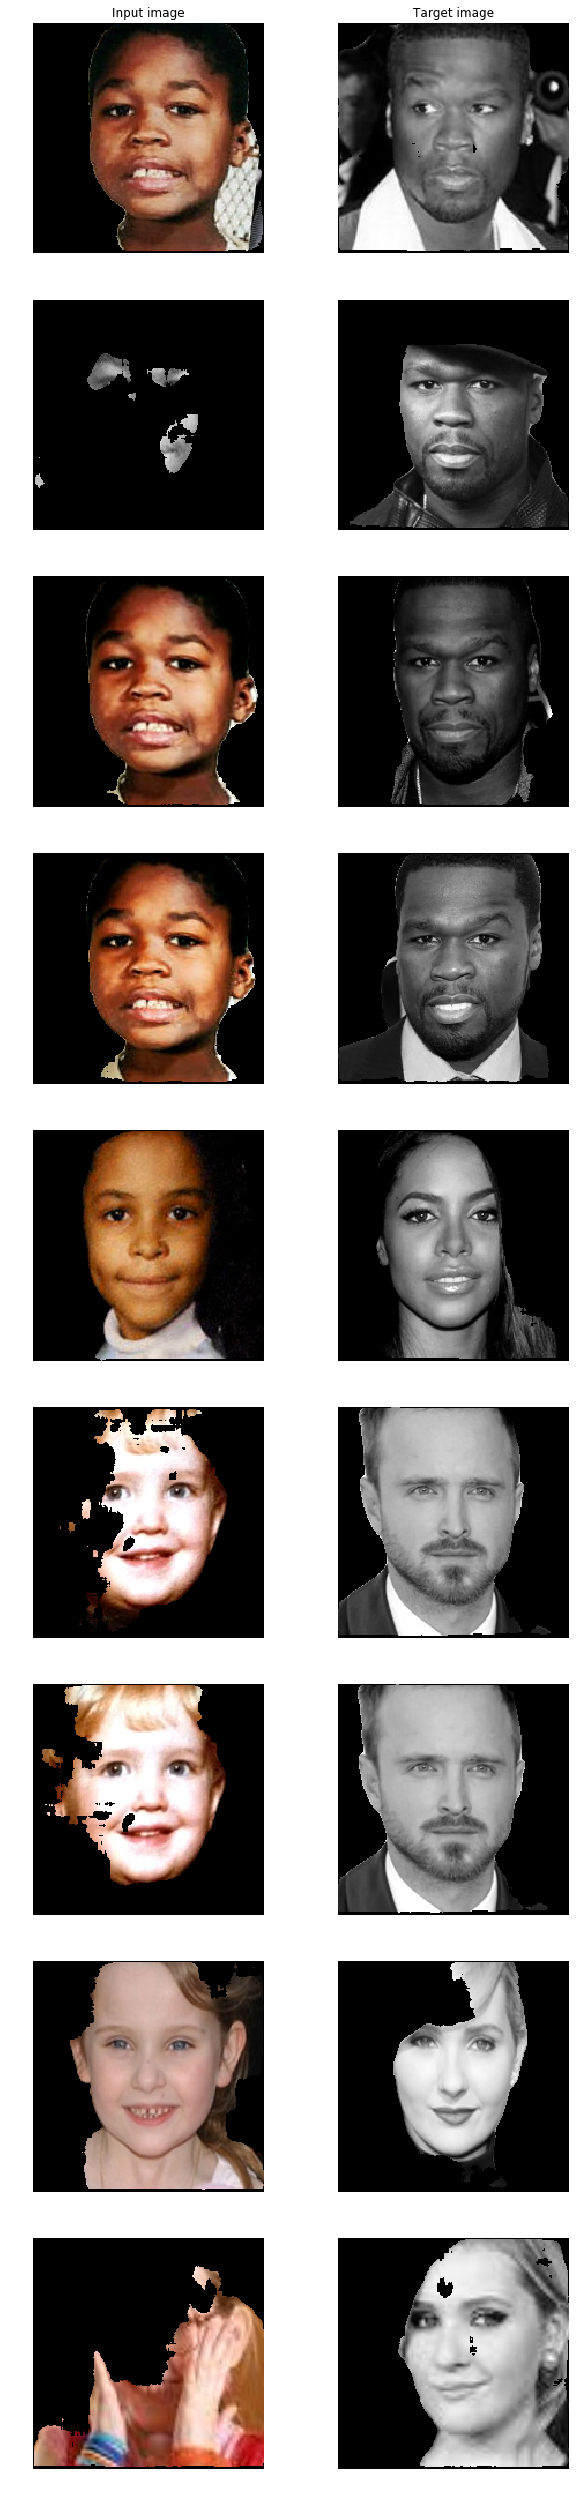

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 9
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(target.numpy().reshape(200,200), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [3]:
from classifiers.segmentation_nn import SegmentationNN
from solver import Solver
import torch.nn.functional as F
import torchvision.models as models

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=4)
model = SegmentationNN()
for param in list(model.parameters())[:-2]:
    param.requires_grad = False
    

solver = Solver(optim_args={"lr": 1e-4,
                            "eps": 1e-8
                            },
                loss_func = torch.nn.CrossEntropyLoss(ignore_index = -1))

solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=80)

START TRAIN.
[Iteration 1/29840] TRAIN loss: 5.663
[Iteration 2/29840] TRAIN loss: 5.636
[Iteration 3/29840] TRAIN loss: 5.651
[Iteration 4/29840] TRAIN loss: 5.647
[Iteration 5/29840] TRAIN loss: 5.641
[Iteration 6/29840] TRAIN loss: 5.648
[Iteration 7/29840] TRAIN loss: 5.671
[Iteration 8/29840] TRAIN loss: 5.638
[Iteration 9/29840] TRAIN loss: 5.643
[Iteration 10/29840] TRAIN loss: 5.654
[Iteration 11/29840] TRAIN loss: 5.673
[Iteration 12/29840] TRAIN loss: 5.641
[Iteration 13/29840] TRAIN loss: 5.651
[Iteration 14/29840] TRAIN loss: 5.652
[Iteration 15/29840] TRAIN loss: 5.650
[Iteration 16/29840] TRAIN loss: 5.652
[Iteration 17/29840] TRAIN loss: 5.664
[Iteration 18/29840] TRAIN loss: 5.661
[Iteration 19/29840] TRAIN loss: 5.648
[Iteration 20/29840] TRAIN loss: 5.661
[Iteration 21/29840] TRAIN loss: 5.638
[Iteration 22/29840] TRAIN loss: 5.664
[Iteration 23/29840] TRAIN loss: 5.642
[Iteration 24/29840] TRAIN loss: 5.649
[Iteration 25/29840] TRAIN loss: 5.665
[Iteration 26/29840] 

[Iteration 209/29840] TRAIN loss: 5.651
[Iteration 210/29840] TRAIN loss: 5.660
[Iteration 211/29840] TRAIN loss: 5.654
[Iteration 212/29840] TRAIN loss: 5.644
[Iteration 213/29840] TRAIN loss: 5.648
[Iteration 214/29840] TRAIN loss: 5.638
[Iteration 215/29840] TRAIN loss: 5.644
[Iteration 216/29840] TRAIN loss: 5.634
[Iteration 217/29840] TRAIN loss: 5.633
[Iteration 218/29840] TRAIN loss: 5.650
[Iteration 219/29840] TRAIN loss: 5.629
[Iteration 220/29840] TRAIN loss: 5.650
[Iteration 221/29840] TRAIN loss: 5.627
[Iteration 222/29840] TRAIN loss: 5.628
[Iteration 223/29840] TRAIN loss: 5.633
[Iteration 224/29840] TRAIN loss: 5.667
[Iteration 225/29840] TRAIN loss: 5.648
[Iteration 226/29840] TRAIN loss: 5.648
[Iteration 227/29840] TRAIN loss: 5.664
[Iteration 228/29840] TRAIN loss: 5.632
[Iteration 229/29840] TRAIN loss: 5.637
[Iteration 230/29840] TRAIN loss: 5.668
[Iteration 231/29840] TRAIN loss: 5.658
[Iteration 232/29840] TRAIN loss: 5.634
[Iteration 233/29840] TRAIN loss: 5.645


RuntimeError: Expected object of type Variable[torch.cuda.LongTensor] but found type Variable[torch.cuda.FloatTensor] for argument #1 'other'

In [4]:
model=torch.load('models/convage_nn_background_90epochs.model')

In [5]:
model.cpu()

ConvAgeNN(
  (down1): VGGDown2(
    (conv1): conv2DRelu(
      (cb_unit): Sequential(
        (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (conv2): conv2DRelu(
      (cb_unit): Sequential(
        (0): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (maxpool_with_argmax): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (down2): VGGDown2(
    (conv1): conv2DRelu(
      (cb_unit): Sequential(
        (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (conv2): conv2DRelu(
      (cb_unit): Sequential(
        (0): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
    )
    (maxpool_with_argmax): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (down3): segnetDown2(
    (conv1): conv2DBatchNormRelu(
 

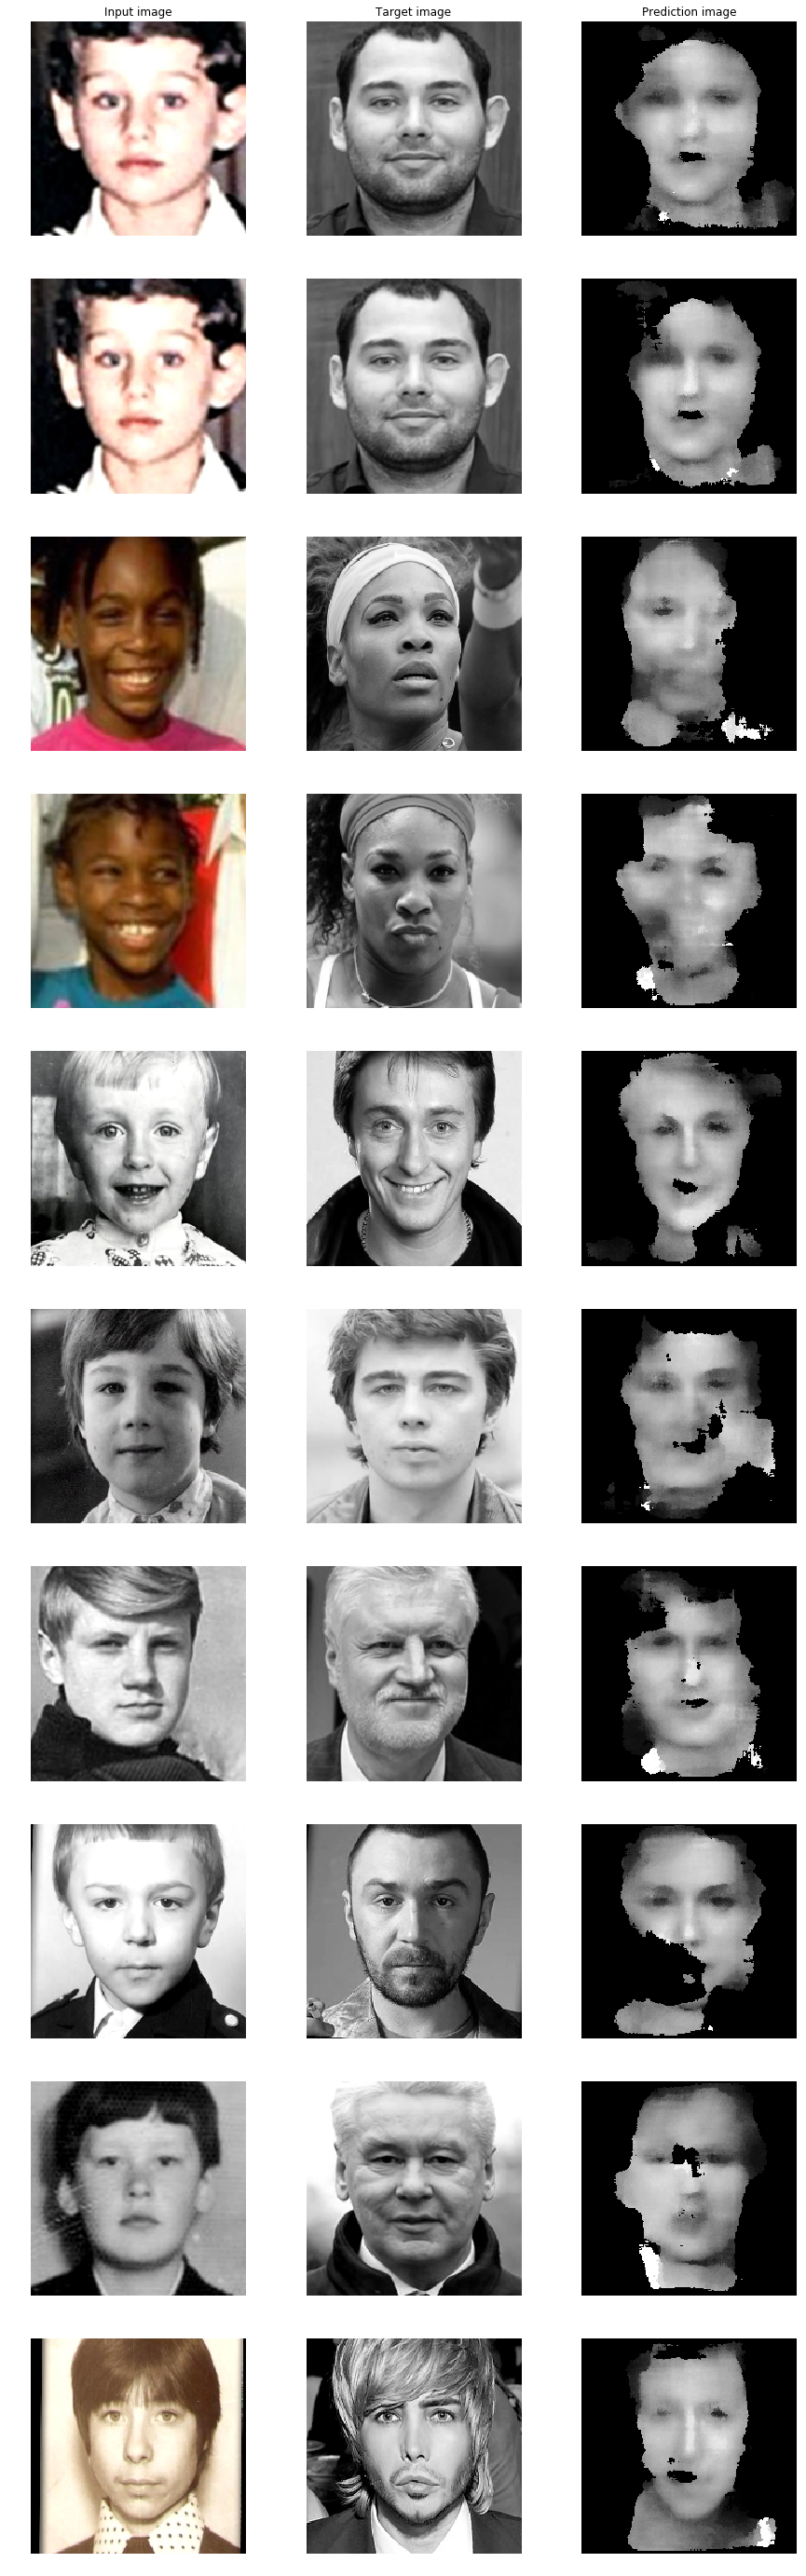

In [10]:
num_example_imgs = 10
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(val_data[40:40+num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    target /= 255
    plt.imshow(target.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Prediction image")
plt.show()